## Data Cleaning and Preprocessing

In [42]:
import pandas as pd
import numpy as np
import ast
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import prepr_functions
from prepr_functions import *

In [43]:
# Player's scraped
players_names = {'Rory McIlroy': '17419',
            'Tiger Woods': '10085', 
            'Jordan Spieth': '19976',
            'Justin Thomas': '20037',
            'Scottie Scheffler': '25786',
            'Collin Morikawa': '33992',
            'Sergio García': '10170',
            'Dustin Johnson': '17976',
            'Phil Mickelson': '10083',
            'Ian Poulter': '11956',
            'Talor Gooch': '27168',
            'Cameron Smith': '27755',
            'Joaquin Niemann': '33997',
            'Bryson DeChambeau': '29148',
            'Brooks Koepka': '25730',
            'Jon Rahm': '28177'}

In [44]:
#Load data
data = pd.read_csv('Press_Conferences.csv', index_col=0, converters={"answer": ast.literal_eval})

### Step 1 - Cleaning

#### Data Cleaning - Adapting data types and formats

In [45]:
#Transform questions using Regex to leave only text
data['question'] = data['question'].str.replace(r"[\['\],]", ' ', regex=True)
data['question'] = data['question'].apply(lambda x: re.sub(' +', ' ', str(x).strip())) #Removes the additional empty spaces between words
data['question'] = data['question'].apply(correct_quoted_contractions)

#Split answer to player / answers then Transform answers using Regex to leave only text
data['player'] = [i for i,n in data['answer']]
data['reply'] = [n for i,n in data['answer']]
data = data.drop(['answer'],axis=1)

#Leave only text
data['reply_sentence'] = data['reply'].apply(list_to_sentence)
data = data.drop(['reply'],axis=1)

#Reseting Index for Date
data = data.reset_index()

#### Transforming 'date' dtype to Datetime

In [46]:
data['date'] = pd.to_datetime(data['date'], format='%B %d, %Y', errors='coerce')
data['date'] = pd.to_datetime(data['date'], errors='coerce')

#Create new columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['year_month'] = data['date'].dt.to_period('M')

##### Create new dataframe for next section

In [47]:
df = data[['date','year_month','year','month','player','question','reply_sentence']]

#### Replacing duplicate names

In [48]:
#Retrieving names for LIV PLAYERS

pattern = re.compile(r'^(ser|dust|phil|ian|talo|came|joa|bry|brook|jon)', flags=re.IGNORECASE)

# Loop over unique player names
for player_name in df['player'].unique():
    matches = pattern.findall(player_name)
    if matches:  # Check if the list of matches is not empty
        print(f"{player_name}: {matches}")

df['player'] = df['player'].replace('joaquín niemann','joaquin niemann').replace('sergio garcía','sergio garcia')

jon rahm: ['jon']
brooks koepka: ['brook']
cameron young: ['came']
sergio garcia: ['ser']
dustin johnson: ['dust']
phil mickelson: ['phil']
joaquin niemann: ['joa']
cameron smith: ['came']
talor gooch: ['talo']
sergio garcía: ['ser']
joaquín niemann: ['joa']
bryson dechambeau: ['bry']
cameron tringale: ['came']
ian poulter: ['ian']


### Step 2 - Dataset Review

In [49]:
# Visualize Dataset
df.head()

,date,year_month,year,month,player,question,reply_sentence
0,2024-03-03,2024-03,2024,3,rory mcilroy,a little bit of a race to the finish for you g...,a week that could have been i felt like most o...
1,2024-03-03,2024-03,2024,3,rory mcilroy,you added this event added valero to be sharpe...,yeah if anything i'm just learning sort of my ...
2,2024-03-03,2024-03,2024,3,rory mcilroy,unless you really think about your week you do...,i'm really happy i got done today because it m...
3,2024-03-03,2024-03,2024,3,rory mcilroy,with shane kind of in contention you're obviou...,it would mean a lot he loves this place and he...
4,2024-02-29,2024-02,2024,2,rory mcilroy,what did you think of your round today,pretty solid some good some not so good really...


##### Create Dummy variable - Player's Current Affiliation

In [50]:
# Players in list currently belong to LIV Tour
selected_players = ['sergio garcia', 'dustin johnson', 'phil mickelson', 'ian poulter', 'talor gooch',
                     'cameron smith', 'joaquin niemann', 'bryson dechambeau', 'brooks koepka', 'jon rahm']

# Create a dummy variable (1 if player is in the list, else 0)
df['LIV_Player'] = df['player'].isin(selected_players).astype(int)

In [51]:
################ Create new Dataframe based on consistent players

df_pre = df.copy()

## Step 3 - Filter for documents that include pga or liv

In [52]:
#Filtering PGA and LIV Documents

condition_pga = (df_pre['reply_sentence'].str.contains('pga', case=False) | df_pre['question'].str.contains('pga', case=False))
condition_liv = (df_pre['reply_sentence'].str.contains('liv', case=False) | df_pre['question'].str.contains('liv', case=False))

filtered_df = df_pre[condition_pga | condition_liv]

In [53]:
filtered_df['player'].unique()

array(['rory mcilroy', 'justin rose', 'jon rahm', 'matthew joule',
       'clare bodel', 'briony carlyon', 'tom carlisle', 'mike mccarley',
       'liz hoffman', 'laurence applebaum', 'david mckay',
       'haley peterson', 'john dever', 'julius mason', 'tiger woods',
       'jordan spieth', 'justin thomas', 'patrick cantlay', 'chad mumm',
       'billy horschel', 'kevin plank', 'jack ryan', 'sebastian munoz',
       'stuart moffatt', 'john bush', 'scottie scheffler', 'ryan palmer',
       'doug milne', 'collin morikawa', 'wyndham clark',
       'olivia mcmillan', 'max homa', 'sergio garcia', 'david puig',
       'abraham ancer', 'phil mickelson', 'louis oosthuizen',
       'brooks koepka', 'henrik stenson', 'anirban lahiri',
       'carlos ortiz', 'javier reviriego', 'eugenio chacarra',
       'victor gonzález', 'talor gooch', 'scott vincent', 'martin kaymer',
       'lee westwood', 'joaquin niemann', 'dustin johnson',
       'harold varner iii', 'patrick reed', 'bubba watson', 'pat p

In [54]:
# Create dummy variable 'PGA'
filtered_df['PGA'] = (filtered_df['reply_sentence'].str.contains('pga', case=False) | filtered_df['question'].str.contains('pga', case=False)).astype(int)

# Create dummy variable 'LIV'
filtered_df['LIV'] = (filtered_df['reply_sentence'].str.contains('liv', case=False) | filtered_df['question'].str.contains('liv', case=False)).astype(int)

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_82057/642137281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['PGA'] = (filtered_df['reply_sentence'].str.contains('pga', case=False) | filtered_df['question'].str.contains('pga', case=False)).astype(int)
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_82057/642137281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LIV'] = (filtered_df['reply_sentence'].str.contains('liv', case=False) | filtered_df['ques

In [55]:
print('Documents that include only PGA: ',filtered_df[(filtered_df['PGA'] == 1) & (filtered_df['LIV']==0)].shape)
print('Documents that include only LIV: ',filtered_df[(filtered_df['PGA'] == 0) & (filtered_df['LIV']==1)].shape)
print('Documents that include only PGA: ',filtered_df[(filtered_df['PGA'] == 1) & (filtered_df['LIV']==1)].shape)

Documents that include only PGA:  (910, 10)
Documents that include only LIV:  (1046, 10)
Documents that include only PGA:  (253, 10)


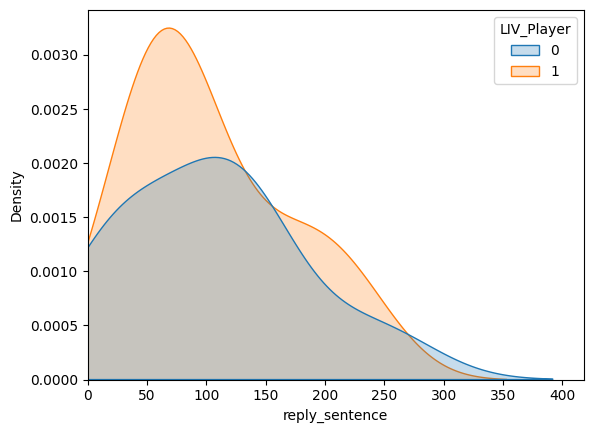

In [56]:
filtered_df1 = filtered_df.copy()
#filtered_df1 = filtered_df[(filtered_df['PGA'] == 0) & (filtered_df['LIV']==1)]
answer_players = freq_table(filtered_df1,'player','reply_sentence',False)
answer_players['LIV_Player'] = answer_players['player'].isin(selected_players).astype(int)


#sns.histplot(data=answer_players.head(18), x='reply_sentence', bins=30, hue='LIV_Player', kde=True)
sns.kdeplot(data=answer_players.head(18), x='reply_sentence', hue='LIV_Player', fill=True)
plt.xlim(0, None)
# Show the plot
plt.show()

,player,reply_sentence,total,perc,accum,LIV_Player
72,rory mcilroy,244,2209,0.11,0.11,0
71,phil mickelson,227,2209,0.10,0.21,1
43,jon rahm,191,2209,0.09,0.30,1
9,brooks koepka,159,2209,0.07,0.37,1
76,scottie scheffler,136,2209,0.06,0.43,0
47,justin thomas,132,2209,0.06,0.49,0


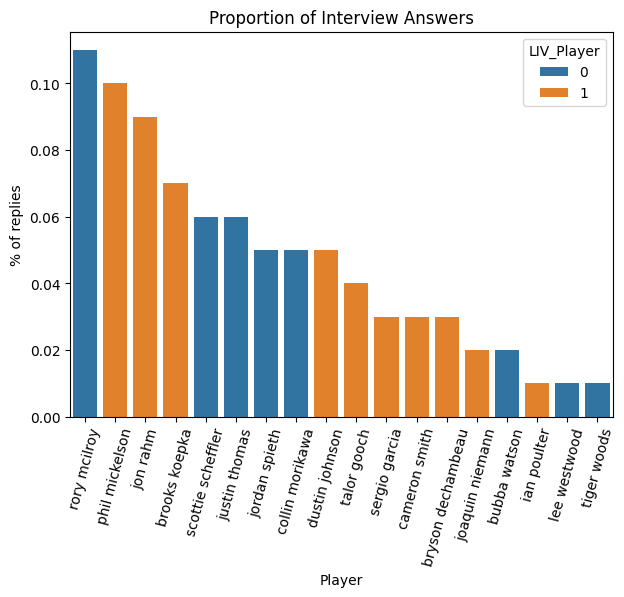

In [57]:
display(answer_players.head(6))


# Create a bar plot
plt.figure(figsize=(7, 5))
sns.barplot(data=answer_players.head(18), x='player', y='perc',hue='LIV_Player', palette=['#1f77b4', '#ff7f0e'])
plt.xticks(rotation=75)
plt.title('Proportion of Interview Answers')
plt.xlabel('Player')
plt.ylabel('% of replies')
plt.show()

# Players: 89   # Months:  42


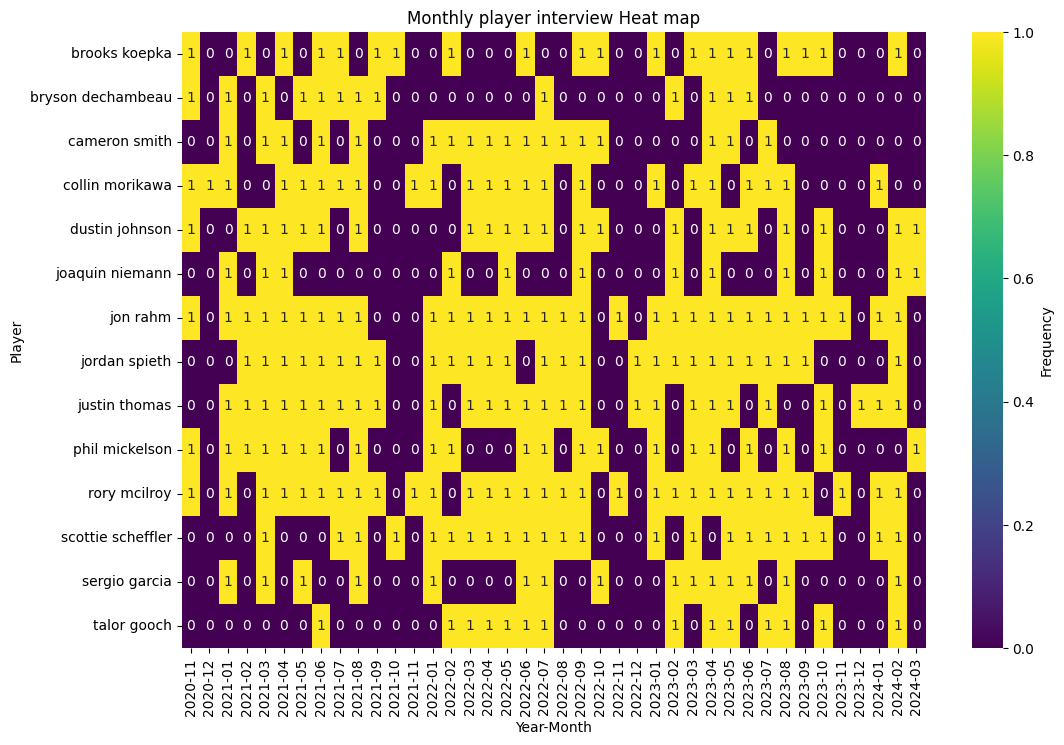

In [58]:
############ Creating a Support Table (Aggregated by player and year-month, Count of replies)

top_players = answer_players['player'].head(18)
player_month = filtered_df1[filtered_df1['player'].isin(top_players)].groupby(['player','year_month'])['reply_sentence'].count().reset_index()
player_month = player_month.sort_values(by=['player','year_month'],ascending=[True,True])


############ Creating a Frequency Matrix

# Creating a Frequency matrix: Players (Rows) year-month (Columns)
frq_table = pd.crosstab(index=filtered_df1['player'].astype(str), columns=filtered_df1['year_month'].astype(str), margins=False).round(2)

# Apply the function to each row and create a new column 'nonzero_count'
frq_table['nonzero_count'] = frq_table.apply(count_nonzero_columns, axis=1)
frq_table = frq_table.sort_values(by='nonzero_count',ascending=False)
print('# Players:',frq_table.shape[0],' ', '# Months: ',frq_table.shape[1])


############ Merge player-month interview count with our non-zero months counter.

frq_table_sub = frq_table[['nonzero_count']].reset_index()
frq_table_sub = frq_table_sub[['player','nonzero_count']]

#Merging
player_month = player_month.merge(frq_table_sub,how='left',on='player')
# Sorting + filtering >50% months
player_month = player_month.sort_values(by=['nonzero_count','player','year_month'],ascending=[False,False,True])
player_month_top = player_month[player_month['nonzero_count'] >= 10]


############ Plotting Heat Map
pivot_table = player_month_top.pivot_table(index='player', columns='year_month', values='reply_sentence', aggfunc='count', fill_value=0)

# Create a heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='g', cbar_kws={'label': 'Frequency'})

# Set plot labels and title
plt.xlabel('Year-Month')
plt.ylabel('Player')
plt.title('Monthly player interview Heat map')

# Show the plot
plt.show()

### Step 3 - Aggregate replies by player, year_month ,PGA and LIV

In [59]:
analysis_list = player_month_top['player'].unique().tolist()

################ Create new Dataframe

filtered_df = filtered_df[filtered_df['player'].isin(analysis_list)]

#Data will be used 
filtered_df.player.unique()

array(['rory mcilroy', 'jon rahm', 'jordan spieth', 'justin thomas',
       'scottie scheffler', 'collin morikawa', 'sergio garcia',
       'phil mickelson', 'brooks koepka', 'talor gooch',
       'joaquin niemann', 'dustin johnson', 'bryson dechambeau',
       'cameron smith'], dtype=object)

In [60]:
# First Step Create the base table with Liv_player and reply_length aggregated
filtered_df['reply_length'] = [len(i.split()) for i in filtered_df['reply_sentence']]
df_pre_month = filtered_df.groupby(['player', 'year_month','PGA','LIV']).agg({'LIV_Player': 'max', 'reply_length': 'sum'}).reset_index()
#Concatenate separately replies and questions by month 
monthly_aggregated_reply = filtered_df.groupby(['player', 'year_month','PGA','LIV'])['reply_sentence'].agg(lambda x: ' '.join(x)).reset_index(name='concatenated_interviews')
monthly_aggregated_quest = filtered_df.groupby(['player', 'year_month','PGA','LIV'])['question'].agg(lambda x: ' '.join(x)).reset_index(name='concatenated_questions')

In [61]:
#Merge tables
df_month = df_pre_month.merge(monthly_aggregated_reply,how='left',on=['player', 'year_month','PGA','LIV'],suffixes=('sub','ex'))
df_month = df_month.merge(monthly_aggregated_quest,how='left',on=['player', 'year_month','PGA','LIV'],suffixes=('on','wh'))

In [62]:
df_month

,player,year_month,PGA,LIV,LIV_Player,reply_length,concatenated_interviews,concatenated_questions
0,brooks koepka,2020-11,0,1,1,154,no it's not that i regret not taking time off ...,MODERATOR
1,brooks koepka,2020-11,1,0,1,98,i mean it hurt physically that wasn't fun but ...,MODERATOR
2,brooks koepka,2021-02,0,1,1,254,deep down yeah i did i don't know it's what i ...,so you had i guess months or so of being injur...
3,brooks koepka,2021-02,1,0,1,61,it's a good feeling it's been so long to me ye...,you have such a focus around the majors how go...
4,brooks koepka,2021-04,1,0,1,199,i wouldn't have been playing for another month...,if it wasn't masters week would you have taken...
...,...,...,...,...,...,...,...,...
536,talor gooch,2023-07,1,0,1,228,if you look at my career my first year on the ...,your change in form this year two wins already...
537,talor gooch,2023-07,1,1,1,229,it's always fun playing with harold in the uk ...,talor it's obviously undeniable that the stren...
538,talor gooch,2023-08,0,1,1,34,i think that what i think doesn't matter for i...,talor you're clearly one of the most consisten...
539,talor gooch,2023-10,0,1,1,3039,not my life but the goal is to change a lot of...,that being said when you see the amount of mon...


#### What is the word distribution per reply after aggregating by player & year_month?

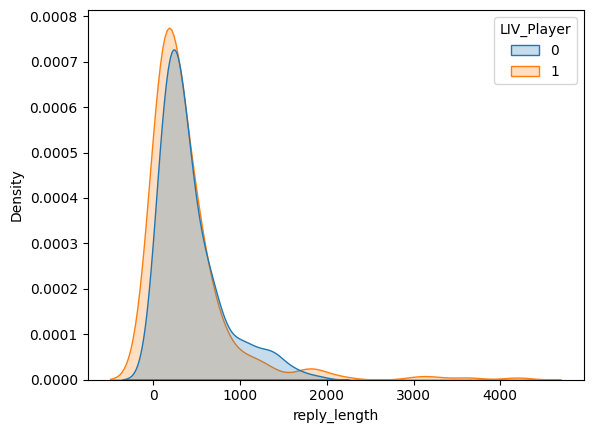

In [63]:
sns.kdeplot(data=df_month, x='reply_length', hue='LIV_Player', fill=True)
#plt.xlim(0, None)
# Show the plot
plt.show()

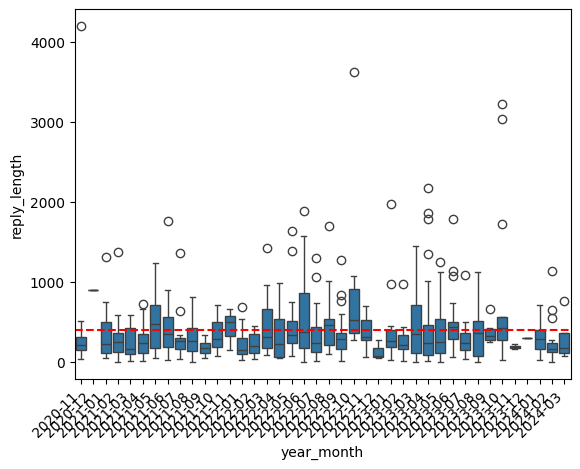

In [64]:
df_month_ordered = df_month.sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_month_ordered, x='year_month', y='reply_length', fill=True)
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_month_ordered['reply_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean Reply Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

### Step 4 - Incorporate Target Variable ( 1: Player switch to LIV  ,    0: No movement )

In [65]:
# List of players and their corresponding specific dates
players_and_dates = {
    'sergio garcia': pd.Period('2022-06'),
    'dustin johnson': pd.Period('2022-06'),
    'phil mickelson': pd.Period('2022-06'),
    'ian poulter': pd.Period('2022-06'),
    'talor gooch': pd.Period('2022-06'),
    'cameron smith': pd.Period('2022-08'),
    'joaquin niemann': pd.Period('2022-09'),
    'bryson dechambeau': pd.Period('2022-06'),
    'brooks koepka': pd.Period('2022-06'),
    'jon rahm': pd.Period('2023-12'),
    # Add more players and dates as needed
}
df_month['LIV_CHANGE'] = df_month.apply(lambda row: 1 if (row['player'].lower() in players_and_dates and row['year_month'] == players_and_dates[row['player'].lower()]) else 0, axis=1)
df_month['year'] = df_month['year_month'].dt.year
df_month = df_month[['player','LIV_Player','year_month','year','reply_length','PGA','LIV','concatenated_interviews','concatenated_questions','LIV_CHANGE']]
df_month

,player,LIV_Player,year_month,year,reply_length,PGA,LIV,concatenated_interviews,concatenated_questions,LIV_CHANGE
0,brooks koepka,1,2020-11,2020,154,0,1,no it's not that i regret not taking time off ...,MODERATOR,0
1,brooks koepka,1,2020-11,2020,98,1,0,i mean it hurt physically that wasn't fun but ...,MODERATOR,0
2,brooks koepka,1,2021-02,2021,254,0,1,deep down yeah i did i don't know it's what i ...,so you had i guess months or so of being injur...,0
3,brooks koepka,1,2021-02,2021,61,1,0,it's a good feeling it's been so long to me ye...,you have such a focus around the majors how go...,0
4,brooks koepka,1,2021-04,2021,199,1,0,i wouldn't have been playing for another month...,if it wasn't masters week would you have taken...,0
...,...,...,...,...,...,...,...,...,...,...
536,talor gooch,1,2023-07,2023,228,1,0,if you look at my career my first year on the ...,your change in form this year two wins already...,0
537,talor gooch,1,2023-07,2023,229,1,1,it's always fun playing with harold in the uk ...,talor it's obviously undeniable that the stren...,0
538,talor gooch,1,2023-08,2023,34,0,1,i think that what i think doesn't matter for i...,talor you're clearly one of the most consisten...,0
539,talor gooch,1,2023-10,2023,3039,0,1,not my life but the goal is to change a lot of...,that being said when you see the amount of mon...,0


## Step 5 - Preprocessing

In [66]:
import os
import csv
from tqdm import tqdm # Tracking loading progress
tqdm.pandas()
# Preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords # Add MODERATOR TO THE STOPWORDS LIST
#!python -m spacy download en_core_web_sm
import spacy
import pickle
sp = spacy.load('en_core_web_sm')
#Regex
import re

#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#Text Mining & Dimensionality Reduction
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation

In [67]:
## Preprocesing both interviews and questions
df_month['interv_prepr'] = txtprocess_tok(df_month,'concatenated_interviews',2)
df_month['quest_prepr'] = txtprocess_tok(df_month,'concatenated_questions',2)

df_month = df_month[['player','LIV_Player','year_month','year','reply_length','PGA','LIV','interv_prepr','quest_prepr','concatenated_interviews','concatenated_questions','LIV_CHANGE']]


  0%|          | 0/541 [00:00<?, ?it/s]

100%|██████████| 541/541 [00:29<00:00, 18.43it/s]
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_82057/2931497830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['interv_prepr'] = txtprocess_tok(df_month,'concatenated_interviews',2)
100%|██████████| 541/541 [00:07<00:00, 69.19it/s]
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_82057/2931497830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['quest_prepr'] = txtprocess_tok(df_month,'concatenated_questions',2

(541, 12)

In [77]:
## Concatenate question*3 + reply after preprocessing

df_month['three_question_text']=df_month['interv_prepr']+' '+df_month['quest_prepr']+' '+df_month['quest_prepr']+' '+df_month['quest_prepr']

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_82057/3116489139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['three_question_text']=df_month['interv_prepr']+' '+df_month['quest_prepr']+' '+df_month['quest_prepr']+' '+df_month['quest_prepr']


### Check text after preprocessing

In [79]:
for i in df_month['three_question_text'][67:69]:
    print(i)

yeah think pga probably one struggle typically set demand tee think really strong suit ever lot work last week driver try get straight rather try get little bit distance yeah opportunity fairway think need especially around rough pretty penal yeah think course get good mix long short hole think go quite windy might wood long iron tee bit thinker golf course around really like reset every major every tournament carry frustrating pretty well major get finish line frustrating anything regret really great result major start new season look major term fondness setup course know great result augusta would sort pga championship rate start new season look towards four major reset every major every tournament carry frustrating pretty well major get finish line frustrating anything regret really great result major start new season look major term fondness setup course know great result augusta would sort pga championship rate start new season look towards four major reset every major every tourn

In [82]:
df_month = df_month[['player','LIV_Player','year_month','year','reply_length','PGA','LIV','interv_prepr','quest_prepr','three_question_text'
,'LIV_CHANGE','concatenated_interviews','concatenated_questions']]
df_month.head()

,player,LIV_Player,year_month,year,reply_length,PGA,LIV,interv_prepr,quest_prepr,three_question_text,LIV_CHANGE,concatenated_interviews,concatenated_questions
0,brooks koepka,1,2020-11,2020,154,0,1,regret take time one thing regret really right...,,regret take time one thing regret really right...,0,no it's not that i regret not taking time off ...,MODERATOR
1,brooks koepka,1,2020-11,2020,98,1,0,mean hurt physically fun mean put contention l...,,mean hurt physically fun mean put contention l...,0,i mean it hurt physically that wasn't fun but ...,MODERATOR
2,brooks koepka,1,2021-02,2021,254,0,1,deep yeah know live live moment get close get ...,guess month injure fan injury bad fan sort add...,deep yeah know live live moment get close get ...,0,deep down yeah i did i don't know it's what i ...,so you had i guess months or so of being injur...
3,brooks koepka,1,2021-02,2021,61,1,0,good feeling long yeah lot day last year head ...,focus around major good feel win pga tour title,good feeling long yeah lot day last year head ...,0,it's a good feeling it's been so long to me ye...,you have such a focus around the majors how go...
4,brooks koepka,1,2021-04,2021,199,1,0,would play another month week take nice long b...,master week would take another week two next t...,would play another month week take nice long b...,0,i wouldn't have been playing for another month...,if it wasn't masters week would you have taken...


### Step 6 - Normalization 

In [24]:
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.05, max_df=0.4, stop_words='english')
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv = TfidfVectorizer(ngram_range = (1,2), norm='l2', lowercase=True, min_df=0.05, max_df=0.9, stop_words='english')
cv.fit(df_month['interv_prepr'])

vectorized_text=cv.transform(df_month['interv_prepr'])
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

# Same transformation for questions
vectorized_title=cv.transform(df_month['quest_prepr'])
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)

document term matrix has size (344, 1642)
['ability' 'able come' 'able hit' ... 'yesterday today' 'young'
 'young guy']
document term matrix has size (344, 1642)


### Step 7 - Dimensionality Reduction

U (document-topic matrix): Each row in U represents a document (in our case, a sentence) in the new topic space defined by SVD. The values indicate how strongly each document is associated with a topic.

Sigma (singular values): The values in Σ represent the strength or importance of each topic uncovered by SVD. Higher values mean the topic is more significant in capturing the variance (or information) in the dataset.

VT (topic-term matrix): Each row in V^T represents a topic, and the values indicate how each term is associated with that topic. This helps in understanding what each topic is about.

In [25]:
# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(vectorized_text)
Sigma = svd.singular_values_
VT = svd.components_

In [26]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('sort', 0.15685823072376562), ('open', 0.0956999436773018), ('major', 0.09367779735785327), ('match', 0.08821383458568245), ('remember', 0.08118300683229066)]
Topic 2:  [('sort', 0.8993323916232246), ('certainly', 0.1126152171403353), ('dubai', 0.07986329653355438), ('yeah look', 0.04981482016155139), ('open', 0.0397122186404262)]
Topic 3:  [('ryder', 0.2607799961944626), ('ryder cup', 0.2590257498183787), ('cup', 0.255320798614069), ('match', 0.19885090207139874), ('liv', 0.1743756102257751)]
Topic 4:  [('match', 0.21155901966858034), ('yeah obviously', 0.16304943026225438), ('solid', 0.1583770845803349), ('excited', 0.1433858608816516), ('nicely', 0.13864113236825298)]
Topic 5:  [('liv', 0.34392771686217133), ('game golf', 0.1342694536812669), ('support', 0.11822007853048852), ('compete', 0.11706083960207896), ('pga', 0.10917178246139911)]
Topic 6:  [('match', 0.39799952297217545), ('match play', 0.1567887665911619), ('liv', 0.13262961336677523), ('certainly', 0.111190384

#### Same for Interview questions

In [27]:
svd1 = TruncatedSVD(n_components=10)
svd1.fit(vectorized_text)
U1 = svd1.transform(vectorized_title)
Sigma1 = svd1.singular_values_
VT1 = svd1.components_

In [136]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT1):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('sort', 0.15685823078621036), ('open', 0.09569994351469387), ('major', 0.0936777975101002), ('match', 0.08821383384539117), ('remember', 0.0811830071491844)]
Topic 2:  [('sort', 0.8993360728266798), ('certainly', 0.11260657914188191), ('dubai', 0.0798565386288245), ('yeah look', 0.04981467084715237), ('open', 0.039725375468140874)]
Topic 3:  [('ryder', 0.2608152899507817), ('ryder cup', 0.25906050400158037), ('cup', 0.2553084832322517), ('match', 0.19900603247932672), ('liv', 0.17424523521793386)]
Topic 4:  [('match', 0.21143616343792715), ('yeah obviously', 0.16272369069593243), ('solid', 0.1572993099783532), ('excited', 0.14334844993870044), ('nicely', 0.14066585489120148)]
Topic 5:  [('liv', 0.3444111768299333), ('game golf', 0.13387386228611617), ('support', 0.11816347635100244), ('compete', 0.11714929328553307), ('pga', 0.10958117447862557)]
Topic 6:  [('match', 0.3945956205851368), ('match play', 0.15436422933450655), ('liv', 0.1308436615364172), ('certainly', 0.11638

### Experiment for Labeling original dataset

In [35]:
df_test = df_pre.copy()
## Preprocesing both interviews and questions
df_test['interv_pre'] = txtprocess_tok(df_test,'reply_sentence',2)
df_test['quest_pre'] = txtprocess_tok(df_test,'question',2)

100%|██████████| 14815/14815 [01:01<00:00, 239.10it/s]


In [39]:

vectorized_text2=cv.transform(df_test['interv_pre'])
vectorized_text2=vectorized_text2.toarray()
#vectorized_text2 = vectorized_text2.todense()

#SVD
U_original = svd.transform(vectorized_text2)

#Applying Labels
df_test['topic_label'] = np.argmax(U_original, axis=1)

In [47]:
for i in df_test[df_test['topic_label'] == 5]['interv_pre'][20:50]:
    print(i)

finish yesterday plenty time rest get ready morning pretty much say tough week sometimes get wrong side thing like brooks go decide go play terrible kind start party get bad start thing spiral control emotional round care lot tournament one favourite tournament year team event tough beat like guy say feel like close group guy time feel like let guy put morning get point far play three match feel like good chance get point friday go saturday morning able get much momentum go pretty tough go first today want could get point board team want come fight doubt put another good fight another halve tough really know say want win match today guy really long answer short one want win match teammate pretty much
drink ton livpur hydration packet think overdo yeah try force try force food get anything continue energy hot hot lot go sit say kind heat come scottish british certainly little bit different
yeah guess like left arm elbow feel anything get try lock left side may little bent good traction 